In [1]:
from imblearn.over_sampling import SMOTE
import sklearn as sk
from sklearn.neural_network import MLPClassifier
import random as rnd
import matplotlib.pyplot as plt
import joblib
import dataframe_image as dfi
import seaborn as sns

In [2]:
%run -i src/data_preproc.py

Reading file: orbis_active_be.xlsx ...
Reading file: orbis_active_de.xlsx ...
Reading file: orbis_active_dk.xlsx ...
Reading file: orbis_active_es.xlsx ...
Reading file: orbis_active_fin.xlsx ...
Reading file: orbis_active_fra.xlsx ...
Reading file: orbis_active_it.xlsx ...
Reading file: orbis_active_no.xlsx ...
Reading file: orbis_active_rest.xlsx ...
Reading file: orbis_active_se.xlsx ...
Reading file: orbis_default.xlsx ...


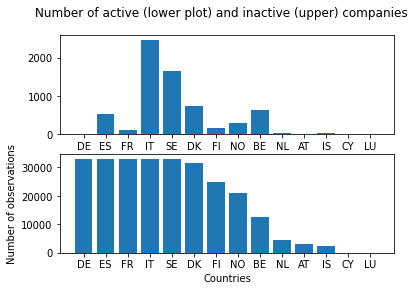

In [3]:
barplot_df = (df
            .groupby('country')['Inactive']
            .agg([('n_inactive', lambda x: np.sum(x == 1)), 
                  ('n_active', lambda x: np.sum(x == 0))]).\
            pipe(lambda df: df.assign(inactive_share = lambda column: column.n_inactive / (column.n_active + column.n_inactive)))
            .reset_index()
            .sort_values(by='n_active', ascending=False))

fig, axs = plt.subplots(2)
fig.suptitle('Number of active (lower plot) and inactive (upper) companies')
axs[0].bar(barplot_df.country, barplot_df.n_inactive)
axs[1].bar(barplot_df.country, barplot_df.n_active)
plt.xlabel("Countries")
plt.ylabel("Number of observations")
plt.savefig('latex/img/country_n.png', dpi=150)

<AxesSubplot:>

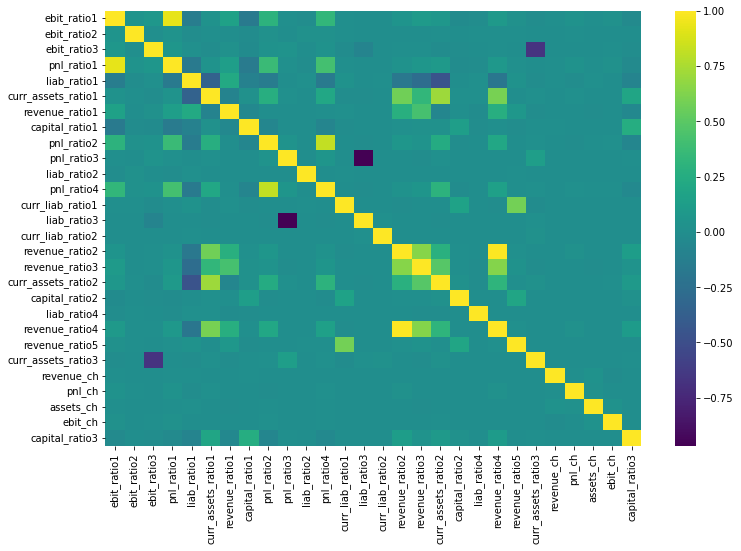

In [4]:


plt.figure(figsize=(12, 8))
sns.heatmap(df.loc[:, df.columns.str.contains('ratio|ch')].dropna().apply(pd.to_numeric).corr(), cmap='viridis')

In [5]:
# NAs share among original variables
(df.loc[:, ~df.columns.str.contains('ratio|ch|sector_|lag')].isna().sum() / df.shape[0]).sort_values(ascending=False)[:10]

revenue         0.209211
lt_debt         0.121432
cash            0.089731
capital         0.056358
sector          0.051112
ebit            0.046152
fixed_assets    0.046049
assets_log      0.046042
assets          0.046042
curr_liab       0.046038
dtype: float64

In [6]:
split_share = 0.8

rnd.seed(1)
train_id = rnd.sample(range(df.shape[0]), round(df.shape[0] * split_share))

train_df = df.drop(['country', 'last_year', 'sector'], axis=1).loc[train_id]
test_df  = df.drop(['country', 'last_year', 'sector'], axis=1).loc[~np.isin(list(range(df.shape[0])), train_id)]

In [7]:

# univariate imputing with train dataset median of given variable. 
for variable in train_df.loc[:, train_df.apply(lambda x: any(x.isna()))].columns:
    train_df.loc[train_df[variable].isna(), variable] = train_df[variable].median()
    test_df.loc[test_df[variable].isna(), variable] = test_df[variable].median()

# idea to implement: multivariate LM imputing based on no NAs variable

In [8]:
rnd.seed(1)

def undersampling(df, class_variable, rate):
    indexes = rnd.sample(list(df[df[class_variable] == 0].index), k = round(np.sum(df[class_variable] == 1) * rate))
    train_df = pd.concat([df.loc[df[class_variable] == 1], df.loc[indexes]])
    return train_df

df_train_us = undersampling(train_df, 'Inactive', 1) # undersampling to 1:1 relation
df_train_sm = undersampling(train_df, 'Inactive', 3) # undersampling to 2:1 relation for SMOTE
X_train_us = df_train_us.loc[:, df_train_us.columns != 'Inactive']
y_train_us = df_train_us.Inactive

In [9]:
X_train_sm, y_train_sm = SMOTE(random_state=1).fit_resample(df_train_sm.loc[:,~np.isin(df_train_sm.columns, 'Inactive')], df_train_sm['Inactive'])

In [10]:
rnd.seed(1)

os_indexes = rnd.choices(list(train_df[train_df.Inactive == 1].index), k = np.sum(train_df.Inactive == 0) - np.sum(train_df.Inactive == 1))
train_df_os = pd.concat([train_df.loc[os_indexes,:], train_df])

X_train_os = train_df_os.loc[:, train_df_os.columns != 'Inactive']
y_train_os = train_df_os.Inactive

In [11]:
{'SMOTE n observations': y_train_sm.shape[0],
 'Undersampling n observations': y_train_us.shape[0],
 'Oversampling n observations': y_train_os.shape[0]}


{'SMOTE n observations': 32136,
 'Undersampling n observations': 10712,
 'Oversampling n observations': 423850}

In [12]:
#%run -i models/logistic_regression.py 
# approx time: 42 mins

In [13]:
#%run -i models/mlpc.py
# approx time: 47 mins

In [14]:
#%run -i models/xgb.py
# approx. time: 38 mins

In [15]:
# this code chunk loads pretraiend models
# if you wish to train them once again run code chunks above
logit_os = joblib.load('models/logit_os.sav')
logit_us = joblib.load('models/logit_us.sav')
logit_sm = joblib.load('models/logit_sm.sav')

mlpc_us = joblib.load('models/mlpc_us.sav')
mlpc_os = joblib.load('models/mlpc_os.sav')
mlpc_sm = joblib.load('models/mlpc_sm.sav')

xgb_us = joblib.load('models/xgb_us.sav')
xgb_os = joblib.load('models/xgb_os.sav')
xgb_sm = joblib.load('models/xgb_sm.sav')

In [16]:
%run -i "src/pred_metrics_class.py"

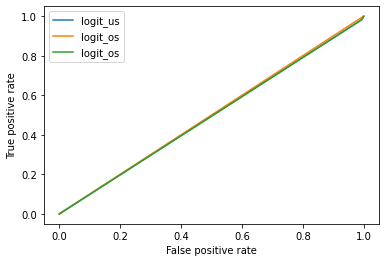

In [17]:
metrics_logit_us = PredMetrics(pred_pd = logit_us.predict_proba(test_df.loc[:,test_df.columns != 'Inactive'])[:,1],
                       actual = np.array(test_df.Inactive))
metrics_logit_os = PredMetrics(pred_pd = logit_os.predict_proba(test_df.loc[:,test_df.columns != 'Inactive'])[:,1],
                       actual = np.array(test_df.Inactive))
metrics_logit_sm = PredMetrics(pred_pd = logit_sm.predict_proba(test_df.loc[:,test_df.columns != 'Inactive'])[:,1],
                       actual = np.array(test_df.Inactive))

thresholds = np.linspace(start=0, stop=1, num=1000)

labels = ['logit_us', 'logit_os', 'logit_sm']
n = 0

for model in [metrics_logit_us, metrics_logit_os, metrics_logit_sm]:
    fpr = [model.fpr(i) for i in thresholds]
    tpr = [model.tpr(i) for i in thresholds]
    plt.plot(fpr, tpr, label = labels[n])
    n =+ 1

plt.legend()
plt.xlabel("False positive rate")
plt.ylabel("True positive rate")
plt.savefig('latex/img/log_roc.png', dpi=150)
plt.show()

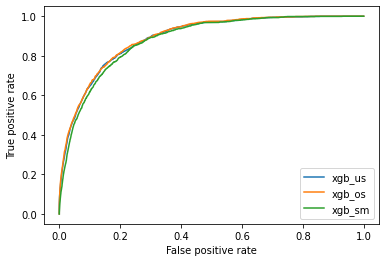

In [18]:
metrics_xgb_us = PredMetrics(pred_pd = xgb_us.predict_proba(np.array(test_df.loc[:,test_df.columns != 'Inactive']))[:,1],
                       actual = np.array(test_df.Inactive))
metrics_xgb_os = PredMetrics(pred_pd = xgb_os.predict_proba(np.array(test_df.loc[:,test_df.columns != 'Inactive']))[:,1],
                       actual = np.array(test_df.Inactive))
metrics_xgb_sm = PredMetrics(pred_pd = xgb_sm.predict_proba(np.array(test_df.loc[:,test_df.columns != 'Inactive']))[:,1],
                       actual = np.array(test_df.Inactive))

thresholds = np.linspace(start=0, stop=1, num=1000)

labels = ['xgb_us', 'xgb_os', 'xgb_sm']
n = 0

for model in [metrics_xgb_us, metrics_xgb_os, metrics_xgb_sm]:
    fpr = [model.fpr(i) for i in thresholds]
    tpr = [model.tpr(i) for i in thresholds]
    plt.plot(fpr, tpr, label = labels[n])
    n += 1

plt.legend()
plt.xlabel("False positive rate")
plt.ylabel("True positive rate")
plt.savefig('latex/img/xgb_roc.png', dpi=150)
plt.show()

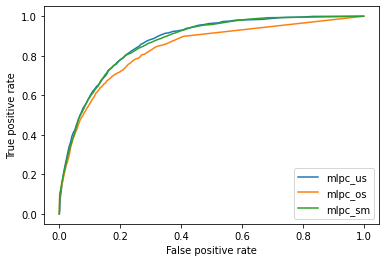

In [19]:
scaler = sk.preprocessing.StandardScaler()

def scale_test(X_train, X_test):
    scaler.fit(X_train)  
    X_test_scaled = scaler.transform(X_test)
    return X_test_scaled

X_test_os = scale_test(X_train_os, test_df.loc[:,test_df.columns != 'Inactive'])
X_test_us = scale_test(X_train_us, test_df.loc[:,test_df.columns != 'Inactive'])
X_test_sm = scale_test(X_train_sm, test_df.loc[:,test_df.columns != 'Inactive'])

metrics_mlpc_us = PredMetrics(pred_pd = mlpc_us.predict_proba(X_test_us)[:,1],
                       actual = np.array(test_df.Inactive))
metrics_mlpc_os = PredMetrics(pred_pd = mlpc_os.predict_proba(X_test_os)[:,1],
                       actual = np.array(test_df.Inactive))
metrics_mlpc_sm = PredMetrics(pred_pd = mlpc_sm.predict_proba(X_test_sm)[:,1],
                       actual = np.array(test_df.Inactive))

thresholds = np.linspace(start=0, stop=1, num=100)

labels = ['mlpc_us', 'mlpc_os', 'mlpc_sm']
n = 0

for model in [metrics_mlpc_us, metrics_mlpc_os, metrics_mlpc_sm]:
    fpr = [model.fpr(i) for i in thresholds]
    tpr = [model.tpr(i) for i in thresholds]
    plt.plot(fpr, tpr, label = labels[n])
    n += 1

plt.legend()
plt.xlabel("False positive rate")
plt.ylabel("True positive rate")
plt.savefig('latex/img/mlpc_roc.png', dpi=150)
plt.show()

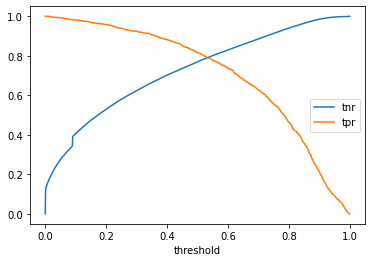

<Figure size 432x288 with 0 Axes>

In [20]:
thresholds = np.linspace(start=0, stop=1, num=1000)

tnr = [metrics_mlpc_us.tnr(i) for i in thresholds]
tpr = [metrics_mlpc_us.tpr(i) for i in thresholds]

plt.plot(thresholds, tnr, label = "tnr")
plt.plot(thresholds, tpr, label = "tpr")
plt.legend()
plt.xlabel('threshold')
plt.show()
plt.savefig('latex/img/mlpc_tnr_tpr.png', dpi=150)

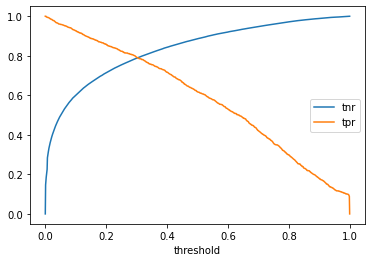

<Figure size 432x288 with 0 Axes>

In [21]:
thresholds = np.linspace(start=0, stop=1, num=1000)

tnr = [metrics_mlpc_sm.tnr(i) for i in thresholds]
tpr = [metrics_mlpc_sm.tpr(i) for i in thresholds]

plt.plot(thresholds, tnr, label = "tnr")
plt.plot(thresholds, tpr, label = "tpr")
plt.legend()
plt.xlabel('threshold')
plt.show()
plt.savefig('latex/img/mlpc_tnr_tpr.png', dpi=150)

In [22]:
model_metrics = {
    'logit_os': metrics_logit_os,
    'logit_us': metrics_logit_us,
    'logit_sm': metrics_logit_sm,
    'xgb_us': metrics_xgb_us,
    'xgb_os': metrics_xgb_os,
    'xgb_sm': metrics_xgb_sm,
    'mlpc_us': metrics_mlpc_us,
    'mlpc_os': metrics_mlpc_os,
    'mlpc_sm': metrics_mlpc_sm
}

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


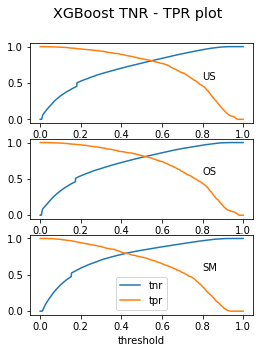

In [23]:
xgb_metrics = {
    'xgb_us': metrics_xgb_us,
    'xgb_os': metrics_xgb_os,
    'xgb_sm': metrics_xgb_sm}

fig, axs = plt.subplots(3)
fig.suptitle('XGBoost TNR - TPR plot', size = 'x-large')

plot = 0
thresholds = np.linspace(start=0, stop=1, num=1000)

for metric in xgb_metrics.keys():
    tnr = [xgb_metrics[metric].tnr(i) for i in thresholds]
    tpr = [xgb_metrics[metric].tpr(i) for i in thresholds]  
    axs[plot].plot(thresholds, tnr, label = "tnr")
    axs[plot].plot(thresholds, tpr, label = "tpr")
    plt.xlabel('threshold')
    plt.legend()
    axs[plot].text(0.8, 0.55, s = str(metric).replace('xgb_', '').upper(), fontsize=10)
    plot += 1

fig.set_size_inches(4, 5)
plt.savefig('latex/img/xgb_tnr_tpr.png', dpi=200)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


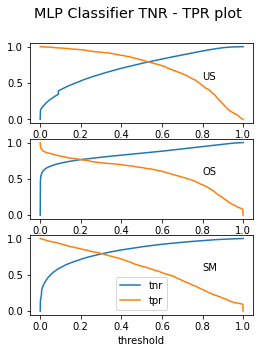

In [24]:
mlpc_metrics = {
    'mlpc_us': metrics_mlpc_us,
    'mlpc_os': metrics_mlpc_os,
    'mlpc_sm': metrics_mlpc_sm}

fig, axs = plt.subplots(3)
fig.suptitle('MLP Classifier TNR - TPR plot', size = 'x-large')

plot = 0
thresholds = np.linspace(start=0, stop=1, num=1000)

for metric in mlpc_metrics.keys():
    tnr = [mlpc_metrics[metric].tnr(i) for i in thresholds]
    tpr = [mlpc_metrics[metric].tpr(i) for i in thresholds]  
    axs[plot].plot(thresholds, tnr, label = "tnr")
    axs[plot].plot(thresholds, tpr, label = "tpr")
    plt.xlabel('threshold')
    plt.legend()
    axs[plot].text(0.8, 0.55, s = str(metric).replace('mlpc_', '').upper(), fontsize=10)
    plot += 1

fig.set_size_inches(4, 5)
plt.savefig('latex/img/mlpc_tnr_tpr.png', dpi=200)

In [25]:

max_balance = pd.DataFrame([])

for metric in model_metrics.keys():
    max_balance = pd.concat([max_balance, model_metrics[metric].max_balanced_acc(1000)], axis=1)

max_balance.columns = model_metrics.keys()
max_balance = max_balance.apply(lambda x: x*100).style.background_gradient(axis=None).format('{:.1f} %')

dfi.export(max_balance,"latex/img/max_balance_table.png")

max_balance

c:\Users\HP\AppData\Local\Programs\Python\Python39\lib\site-packages\dataframe_image\_pandas_accessor.py:69: FutureWarning: this method is deprecated in favour of `Styler.to_html()`
  html = '<div>' + obj.render() + '</div>'


,logit_os,logit_us,logit_sm,xgb_us,xgb_os,xgb_sm,mlpc_us,mlpc_os,mlpc_sm
thresholds,49.9 %,49.0 %,48.9 %,55.4 %,48.3 %,36.5 %,44.3 %,18.1 %,28.6 %
tpr,100.0 %,100.0 %,100.0 %,80.5 %,83.4 %,85.1 %,86.0 %,77.7 %,80.6 %
tnr,0.1 %,0.1 %,0.1 %,80.9 %,78.5 %,75.7 %,73.1 %,75.8 %,77.9 %
balanced_acc,50.0 %,50.0 %,50.0 %,80.7 %,81.0 %,80.4 %,79.6 %,76.7 %,79.2 %


In [26]:
def highlight_max(s, props=''):
    return np.where(s == np.nanmax(s.values), props, '')
    

def highlight_min(s, props=''):
    return np.where(s == np.nanmin(s.values), props, '')

max_balance = pd.DataFrame([])

models_balanced_acc = pd.DataFrame({'balanced accuracy': [model_metrics[metric].balanced_acc(0.5) for metric in model_metrics],
                                    'TPR': [model_metrics[metric].tpr(0.5) for metric in model_metrics],
                                    'TNR': [model_metrics[metric].tnr(0.5) for metric in model_metrics],
                                    'FPR': [model_metrics[metric].fpr(0.5) for metric in model_metrics],
                                    'FNR': [model_metrics[metric].fnr(0.5) for metric in model_metrics]})

models_balanced_acc = models_balanced_acc.transpose()
models_balanced_acc.columns = model_metrics

models_balanced_acc = models_balanced_acc.apply(lambda x: x*100).style.format('{:.1f} %')\
    .background_gradient(axis=None).format('{:.1f} %')

dfi.export(models_balanced_acc,"latex/img/balance_acc_table.png")

models_balanced_acc

c:\Users\HP\AppData\Local\Programs\Python\Python39\lib\site-packages\dataframe_image\_pandas_accessor.py:69: FutureWarning: this method is deprecated in favour of `Styler.to_html()`
  html = '<div>' + obj.render() + '</div>'


,logit_os,logit_us,logit_sm,xgb_us,xgb_os,xgb_sm,mlpc_us,mlpc_os,mlpc_sm
balanced accuracy,59.0 %,52.7 %,56.4 %,80.3 %,80.8 %,79.2 %,79.3 %,75.5 %,75.2 %
TPR,31.4 %,8.1 %,21.2 %,83.3 %,82.1 %,74.5 %,81.6 %,65.6 %,61.8 %
TNR,86.6 %,97.4 %,91.5 %,77.3 %,79.6 %,83.8 %,76.9 %,85.4 %,88.6 %
FPR,13.4 %,2.6 %,8.5 %,22.7 %,20.4 %,16.2 %,23.1 %,14.6 %,11.4 %
FNR,68.6 %,91.9 %,78.8 %,16.7 %,17.9 %,25.5 %,18.4 %,34.4 %,38.2 %


In [27]:
print('Example of interpretation: ')
print('-------------------------')
print('FPR: for an XGBoost model trained on undersampled data (xgb_us), \n the probability of falsely predicting default is: ' + 
str(round(model_metrics['xgb_us'].fpr(0.5), 3) * 100) + "%")
print('-------------------------')
print('TPR: for a Multilayer perceptron model trained on SMOTE data (mlpc_sm), \n the probability of truly predicting default is: ' + 
str(round(model_metrics['mlpc_sm'].tpr(0.5), 3) * 100) + "%")
print('-------------------------')
print('TNR: for a logistic regression model trained on oversampled data (log_os), \n the probability of truly predicting no-default is: ' + 
str(round(model_metrics['mlpc_sm'].tnr(0.5), 3) * 100) + "%")
print('-------------------------')
print('FNR: for an XGBoost model trained on oversampled data (xgb_os), \n the probability of falsely predicting no-default is: ' + 
str(round(model_metrics['mlpc_sm'].fnr(0.5), 3) * 100) + "%")

Example of interpretation: 
-------------------------
FPR: for an XGBoost model trained on undersampled data (xgb_us), 
 the probability of falsely predicting default is: 22.7%
-------------------------
TPR: for a Multilayer perceptron model trained on SMOTE data (mlpc_sm), 
 the probability of truly predicting default is: 61.8%
-------------------------
TNR: for a logistic regression model trained on oversampled data (log_os), 
 the probability of truly predicting no-default is: 88.6%
-------------------------
FNR: for an XGBoost model trained on oversampled data (xgb_os), 
 the probability of falsely predicting no-default is: 38.2%


In [28]:
import dalex as dx

xgb_exp = dx.Explainer(xgb_us, test_df.loc[:,test_df.columns != 'Inactive'].apply(pd.to_numeric), test_df.Inactive)
mlpc_exp = dx.Explainer(mlpc_us, X_test_us, test_df.Inactive)

Preparation of a new explainer is initiated

  -> data              : 54320 rows 87 cols
  -> target variable   : Parameter 'y' was a pandas.Series. Converted to a numpy.ndarray.
  -> target variable   : 54320 values
  -> model_class       : xgboost.sklearn.XGBClassifier (default)
  -> label             : Not specified, model's class short name will be used. (default)
  -> predict function  : <function yhat_proba_default at 0x000001DB95375AF0> will be used (default)
  -> predict function  : Accepts pandas.DataFrame and numpy.ndarray.
  -> predicted values  : min = 0.0065, mean = 0.294, max = 0.973
  -> model type        : classification will be used (default)
  -> residual function : difference between y and yhat (default)
  -> residuals         : min = -0.941, mean = -0.269, max = 0.965
  -> model_info        : package xgboost

A new explainer has been created!
Preparation of a new explainer is initiated

  -> data              : numpy.ndarray converted to pandas.DataFrame. Columns ar

c:\Users\HP\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but MLPClassifier was fitted without feature names
  warnings.warn(
c:\Users\HP\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but MLPClassifier was fitted without feature names
  warnings.warn(


  -> predicted values  : min = 0.0, mean = 0.286, max = 1.0
  -> model type        : classification will be used (default)
  -> residual function : difference between y and yhat (default)
  -> residuals         : min = -1.0, mean = -0.261, max = 0.991
  -> model_info        : package sklearn

A new explainer has been created!


In [ ]:
energia_siciliana

mlpc_exp.predict_parts(energia_siciliana, type = 'break_down',).plot()

In [82]:
energia_siciliana = scale_test(X_train_us, train_df.loc[(train_df.assets == 44741), train_df.columns != 'Inactive'].apply(pd.to_numeric))
energia_siciliana = pd.DataFrame(energia_siciliana)
energia_siciliana.columns = train_df.iloc[:,train_df.columns != 'Inactive'].columns

pred_parts = mlpc_exp.predict_parts(energia_siciliana, type = 'break_down')

pred_parts.plot()

c:\Users\HP\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\base.py:443: UserWarning:

X has feature names, but MLPClassifier was fitted without feature names

c:\Users\HP\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\base.py:443: UserWarning:

X has feature names, but MLPClassifier was fitted without feature names

c:\Users\HP\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\base.py:443: UserWarning:

X has feature names, but MLPClassifier was fitted without feature names

c:\Users\HP\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\base.py:443: UserWarning:

X has feature names, but MLPClassifier was fitted without feature names

c:\Users\HP\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\base.py:443: UserWarning:

X has feature names, but MLPClassifier was fitted without feature names

c:\Users\HP\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\base.py:443: UserWarning:

X has featu

,variable_name,variable_value,variable,cumulative,contribution,sign,position,label
0,intercept,1,intercept,0.285989,0.285989,1.0,88,MLPClassifier
1,52,2.76,52 = 2.76,0.449099,0.163110,1.0,87,MLPClassifier
2,79,1.75,79 = 1.75,0.595509,0.146410,1.0,86,MLPClassifier
3,18,0.2338,18 = 0.2338,0.651210,0.055701,1.0,85,MLPClassifier
4,78,-0.2765,78 = -0.2765,0.690428,0.039218,1.0,84,MLPClassifier
...,...,...,...,...,...,...,...,...
84,50,-0.4049,50 = -0.4049,0.850003,-0.017975,-1.0,4,MLPClassifier
85,85,-0.4775,85 = -0.4775,0.842687,-0.007316,-1.0,3,MLPClassifier
86,54,-0.4579,54 = -0.4579,0.827978,-0.014709,-1.0,2,MLPClassifier
87,27,1.896,27 = 1.896,0.793788,-0.034190,-1.0,1,MLPClassifier


In [32]:
xgb_exp.model_parts().plot(max_vars=80)

c:\Users\HP\AppData\Local\Programs\Python\Python39\lib\site-packages\dalex\model_explanations\_model_performance\utils.py:33: FutureWarning:

The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

c:\Users\HP\AppData\Local\Programs\Python\Python39\lib\site-packages\dalex\model_explanations\_model_performance\utils.py:34: FutureWarning:

The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

c:\Users\HP\AppData\Local\Programs\Python\Python39\lib\site-packages\dalex\model_explanations\_model_performance\utils.py:33: FutureWarning:

The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

c:\Users\HP\AppData\Local\Programs\Python\Python39\lib\site-packages\dalex\model_explanations\_model_performance\utils.py:34: FutureWarning:

The series.append method is deprecated and will be removed from pandas i